# Benchmark des solutions d'extraction de documents
Ce notebook compare trois solutions d'extraction de contenu de documents :
- **Docling v2**
- **LayoutParser**
- **Tesseract + TableBank**

Les métriques évaluées sont :
- **Temps de traitement**
- **Similarité textuelle** (par rapport à un texte de référence)

Une interface permet de visualiser les résultats.

In [ ]:
# Installer Tesseract OCR sur Linux
import getpass, subprocess, platform

def run_sudo(cmd):
    subprocess.run(f"echo {getpass.getpass('Mot de passe sudo : ')} | sudo -S {cmd}", shell=True)

run_sudo("apt update -qq && apt install -y tesseract-ocr -qq")
subprocess.run("tesseract --version", shell=True, check=True)
print(f"\nDétails de l'OS: {platform.platform()}")


In [ ]:
# Installation de pytesseract, docling, layoutparser, kaggle, datasets, panel, ipywidgets via pip
from tqdm import tqdm
import subprocess

# Liste des commandes à exécuter
commands = [
    "pip install -q pytesseract docling layoutparser kaggle datasets panel[recommended] ipywidgets",
    # "pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu125"
]   # " pandas scikit-learn opencv-python-headless"

# Barre de progression
for cmd in tqdm(commands, desc="Installation des dépendances"):
    subprocess.run(cmd, shell=True)


# Jeux de données pour un benchmark IDP (Intelligent Document Processing)

Pour un benchmark orienté IDP (Intelligent Document Processing) avec un objectif métier clair, tel que la transformation de documents non structurés en informations exploitables, voici une sélection de petits jeux de données adaptés :

## 1. FUNSD (Form Understanding in Noisy Scanned Documents)
- **Description** : Un jeu de données contenant 199 formulaires annotés avec des entités liées à leur contenu (en-têtes, questions, réponses). Ces formulaires sont souvent utilisés pour tester la capacité des modèles à extraire et structurer des informations.
- **Lien** : [FUNSD GitHub](https://github.com/microsoft/unilm/tree/master/funsd)
- **Format** : PDF et annotations JSON.
- **Avantages** : Conçu pour les tâches d'extraction de données clés et la structuration de documents semi-structurés.

## 2. CORD (Consolidated Receipt Dataset)
- **Description** : Un jeu de données qui comprend des tickets de caisse annotés pour la reconnaissance des entités (montants, articles, etc.).
- **Lien** : [CORD GitHub](https://github.com/clovaai/cord)
- **Format** : Images et JSON.
- **Avantages** : Idéal pour tester l'extraction d'informations dans des documents commerciaux et structurés.

## 3. Kleister Charity
- **Description** : Un jeu de données conçu pour la classification de documents et l'extraction d'informations à partir de documents longs, notamment des contrats et des rapports.
- **Lien** : [Kleister GitHub](https://github.com/allenai/kleister-charity)
- **Format** : JSON et PDF.
- **Avantages** : Bien adapté pour les cas d'usage métier où les données sont enfermées dans de longs rapports.

## 4. SROIE (Scanned Receipts OCR and Information Extraction)
- **Description** : Un jeu de données qui contient des scans de reçus avec annotations sur des champs spécifiques (nom de l'entreprise, date, montant, etc.).
- **Lien** : [SROIE Resources](https://rrc.cvc.uab.es/?ch=13)
- **Format** : Images et JSON.
- **Avantages** : Permet de tester la capacité à traiter des documents bruités ou mal scannés.

## 5. Invoice Dataset
- **Description** : Un petit jeu de données contenant des factures annotées, conçu pour tester les capacités de reconnaissance des documents structurés.
- **Lien** : [Invoice Dataset Kaggle](https://www.kaggle.com/datasets/ashishraut64/invoice-dataset)
- **Format** : PDF et annotations.
- **Avantages** : Couvre les besoins liés à l'extraction de données dans les cas d'usage financier et administratif.

## 6. RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing)
- **Description** : Un jeu de données comprenant 400 000 pages de documents classées dans 16 catégories (lettres, mémos, bulletins, etc.).
- **Lien** : [RVL-CDIP Details](http://www.cs.cmu.edu/~aharley/rvl-cdip/)
- **Format** : TIFF et catégories.
- **Avantages** : Utile pour tester la classification de documents non structurés.

---

## **Sélection Optimale**
Pour un benchmark léger mais pertinent, il est recommandé de commencer par **FUNSD**, **CORD**, et **SROIE**, car ils couvrent des cas variés d'extraction de données :
1. **Documents semi-structurés** (ex. formulaires).
2. **Documents commerciaux structurés** (tickets, factures).
3. **Documents bruités** (scans de qualité variable).


In [2]:
import os, json, zipfile, shutil
from pathlib import Path
import requests
from datasets import load_dataset
from kaggle.api.kaggle_api_extended import KaggleApi


# Répertoire de téléchargement des datasets
DATASET_DIR = Path("datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Dossier de sortie unique pour tous les fichiers
MERGED_DATASET_DIR = Path("merged_dataset")
MERGED_DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Sources des datasets
DATASET_SOURCES = {
    "FUNSD": {
        "type": "url",
        "url": "https://guillaumejaume.github.io/FUNSD/dataset.zip",
        "zip_name": "funsd.zip",
        "annotation_folder": "dataset/training_data/annotations",
        "image_folder": "dataset/training_data/images",
    },
    "CORD": {
        "type": "huggingface",
        "huggingface_dataset": "naver-clova-ix/cord-v2",
    },
    "SROIE": {
        "type": "kaggle",
        "kaggle_dataset": "urbikn/sroie-datasetv2",
        "zip_name": "sroie-datasetv2.zip",
    },
}

In [37]:
def download_dataset(name, info, download_dir):
    """
    Télécharge un dataset en fonction de son type et sauvegarde les fichiers associés.
    """
    print(f"[INFO] Traitement du dataset : {name}")

    if info["type"] == "url":
        # Gestion pour les fichiers ZIP depuis une URL (FUNSD)
        zip_path = download_dir / info["zip_name"]
        if not zip_path.exists():
            print(f"[INFO] {name} - Téléchargement depuis l'URL : {info['url']}")
            try:
                with requests.get(info["url"], stream=True) as response:
                    response.raise_for_status()
                    with open(zip_path, "wb") as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                print(f"[SUCCESS] {name} - Fichier téléchargé : {zip_path}")
            except Exception as e:
                print(f"[ERROR] {name} - Erreur lors du téléchargement : {e}")
        else:
            print(f"[INFO] {name} - Fichier déjà présent, téléchargement ignoré : {zip_path}")

    elif info["type"] == "huggingface":
        # Gestion pour CORD (Hugging Face)
        dataset_dir = download_dir / name
        annotations_file = dataset_dir / "annotations.json"
        dataset_dir.mkdir(parents=True, exist_ok=True)

        # Téléchargement des images
        print(f"[INFO] {name} - Téléchargement des images depuis Hugging Face")
        try:
            dataset = load_dataset(info["huggingface_dataset"], split="train")
            annotations = []  # Stockage des annotations

            for i, example in enumerate(dataset):
                # Vérifie si l'image existe déjà
                image_path = dataset_dir / f"{name}_image_{i}.jpg"
                if not image_path.exists():
                    if "image" in example and example["image"] is not None:
                        example["image"].save(image_path)
                        print(f"[SUCCESS] {name} - Image sauvegardée : {image_path}")

                # Collecte les annotations
                annotations.append({
                    "file_name": f"{name}_image_{i}.jpg",
                    "annotations": example.get("text", ""),
                    "bbox": example.get("bboxes", []),
                })

            # Vérifie si les annotations existent déjà avant de les sauvegarder
            if not annotations_file.exists():
                with open(annotations_file, "w", encoding="utf-8") as f:
                    json.dump(annotations, f, ensure_ascii=False, indent=4)
                print(f"[SUCCESS] {name} - Annotations sauvegardées : {annotations_file}")
            else:
                print(f"[INFO] {name} - Annotations déjà présentes, téléchargement ignoré : {annotations_file}")

        except Exception as e:
            print(f"[ERROR] {name} - Erreur lors du téléchargement Hugging Face : {e}")

    elif info["type"] == "kaggle":
        # Gestion pour les fichiers ZIP depuis Kaggle (SROIE)
        api = KaggleApi()
        api.authenticate()
        zip_path = download_dir / info["zip_name"]
        if not zip_path.exists():
            print(f"[INFO] {name} - Téléchargement depuis Kaggle : {info['kaggle_dataset']}")
            try:
                api.dataset_download_files(info["kaggle_dataset"], path=download_dir, unzip=False)
                print(f"[SUCCESS] {name} - Fichier téléchargé : {zip_path}")
            except Exception as e:
                print(f"[ERROR] {name} - Erreur lors du téléchargement Kaggle : {e}")
        else:
            print(f"[INFO] {name} - Fichier déjà présent, téléchargement ignoré : {zip_path}")
    
    else:
        print(f"[ERROR] {name} - Type de dataset inconnu")

# Téléchargement des datasets
for dataset_name, dataset_info in DATASET_SOURCES.items():
    download_dataset(dataset_name, dataset_info, DATASET_DIR)

print("[INFO] Téléchargement des datasets terminé.")


[INFO] Traitement du dataset : FUNSD
[INFO] FUNSD - Fichier déjà présent, téléchargement ignoré : datasets/funsd.zip
[INFO] Traitement du dataset : CORD
[INFO] CORD - Téléchargement des images depuis Hugging Face
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_0.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_1.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_2.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_3.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_4.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_5.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_6.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_7.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_8.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_9.jpg
[SUCCESS] CORD - Image sauvegardée : datasets/CORD/CORD_image_10.jpg
[SUCCESS] CORD - Image sauvegardée : d

In [40]:

# Gestion des conflits de noms
def copy_without_overwrite(src, dst_dir):
    dst_path = dst_dir / src.name
    counter = 1
    while dst_path.exists():
        dst_path = dst_dir / f"{src.stem}_{counter}{src.suffix}"
        counter += 1
    shutil.copy(src, dst_path)
    return dst_path.name

# Extraction et fusion pour FUNSD
def process_funsd(funsd_dir, merged_dir):
    print("[INFO] Traitement FUNSD...")
    annotations = []
    for subset in ["training_data", "testing_data"]:
        annotation_dir = funsd_dir / "dataset" / subset / "annotations"
        image_dir = funsd_dir / "dataset" / subset / "images"
        
        for annotation_file in tqdm(annotation_dir.glob("*.json"), desc=f"[FUNSD] {subset}"):
            with open(annotation_file, "r") as f:
                data = json.load(f)
            image_file = image_dir / f"{annotation_file.stem}.png"
            if image_file.exists():
                new_image_name = copy_without_overwrite(image_file, merged_dir)
                text = " ".join([block["text"] for block in data.get("form", [])])
                annotations.append({"file_name": new_image_name, "text": text})
    return annotations

# Extraction et fusion pour SROIE
def process_sroie(sroie_dir, merged_dir):
    print("[INFO] Traitement SROIE...")
    annotations = []
    for subset in ["train", "test"]:
        annotation_dir = sroie_dir / "SROIE2019" / subset / "annotations"
        image_dir = sroie_dir / "SROIE2019" / subset / "images"

        for annotation_file in tqdm(annotation_dir.glob("*.txt"), desc=f"[SROIE] {subset}"):
            with open(annotation_file, "r") as f:
                text = f.read().strip()
            image_file = image_dir / f"{annotation_file.stem}.jpg"
            if image_file.exists():
                new_image_name = copy_without_overwrite(image_file, merged_dir)
                annotations.append({"file_name": new_image_name, "text": text})
    return annotations

# Extraction et fusion pour CORD
def process_cord(cord_dir, merged_dir):
    print("[INFO] Traitement CORD...")
    annotations = []
    with open(cord_dir / "annotations.json", "r") as f:
        data = json.load(f)
    for item in tqdm(data, desc="[CORD]"):
        image_file = cord_dir / item["file_name"]
        if image_file.exists():
            new_image_name = copy_without_overwrite(image_file, merged_dir)
            annotations.append({
                "file_name": new_image_name,
                "text": item.get("text", ""),
                "bboxes": item.get("bboxes", [])
            })
    return annotations

# Fusionner tous les datasets
def merge_datasets():
    all_annotations = []
    # Traiter FUNSD
    funsd_dir = DATASET_DIR / "funsd"
    all_annotations.extend(process_funsd(funsd_dir, MERGED_DATASET_DIR))

    # Traiter SROIE
    sroie_dir = DATASET_DIR / "sroie-datasetv2"
    all_annotations.extend(process_sroie(sroie_dir, MERGED_DATASET_DIR))

    # Traiter CORD
    cord_dir = DATASET_DIR / "CORD"
    all_annotations.extend(process_cord(cord_dir, MERGED_DATASET_DIR))

    # Sauvegarder les annotations fusionnées
    merged_annotations_file = MERGED_DATASET_DIR / "merged_annotations.json"
    with open(merged_annotations_file, "w", encoding="utf-8") as f:
        json.dump(all_annotations, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Annotations fusionnées sauvegardées dans : {merged_annotations_file}")

# Exécution principale
if __name__ == "__main__":
    merge_datasets()


[INFO] Traitement FUNSD...


[FUNSD] training_data: 149it [00:00, 2139.99it/s]
[FUNSD] testing_data: 50it [00:00, 2251.95it/s]


[INFO] Traitement SROIE...


[SROIE] train: 0it [00:00, ?it/s]
[SROIE] test: 0it [00:00, ?it/s]


[INFO] Traitement CORD...


[CORD]: 100%|██████████| 800/800 [00:00<00:00, 4254.93it/s]

[INFO] Annotations fusionnées sauvegardées dans : merged_dataset/merged_annotations.json


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
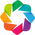

BokehModel(combine_events=True, render_bundle={'docs_json': {'699fe884-6037-4161-8dda-dc5f51ebcc53': {'version…

NameError: name 'Path' is not defined

In [ ]:
import time
import pandas as pd
from difflib import SequenceMatcher
from pdf2image import convert_from_path
import cv2
import pytesseract
import layoutparser as lp
import numpy as np
import holoviews as hv
import panel as pn
from tempfile import NamedTemporaryFile
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.document_converter import DocumentConverter, PdfFormatOption

# Configur
hv.extension("bokeh")
pytesseract.pytesseract_cmd = r'/usr/bin/tesseract'

# Calcul de similarité
def calculate_similarity(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()


# Initialize Docling
def initialize_docling():
    pipeline_options = PdfFormatOption(
        pipeline_options={"do_ocr": True},
        backend=PyPdfiumDocumentBackend
    )
    return DocumentConverter(allowed_formats=["pdf"], format_options={"pdf": pipeline_options})

docling_converter = initialize_docling()

# Traitement avec LayoutParser
def process_with_layoutparser(doc_path):
    try:
        if doc_path.suffix.lower() == ".pdf":
            images = convert_from_path(str(doc_path))
            image = np.array(images[0])
        else:
            image = cv2.imread(str(doc_path))
        
        ocr_agent = lp.TesseractAgent(languages="eng")
        layout = ocr_agent.detect(image)

        # Vérification et extraction robuste des textes
        return " ".join([block.text if hasattr(block, "text") else str(block) for block in layout])
    except Exception as e:
        print(f"Erreur avec LayoutParser : {e}")
        return ""


# Traitement avec Tesseract
def process_with_tesseract(doc_path):
    if doc_path.suffix.lower() == ".pdf":
        images = convert_from_path(str(doc_path))
        image = np.array(images[0])
    else:
        image = cv2.imread(str(doc_path))
    return pytesseract.image_to_string(image)

# Benchmark des modèles
def benchmark_models(doc_files, references):
    results = []
    for file_path in doc_files:
        file_path = Path(file_path)
        reference_text = references.get(file_path.name, "")
        try:
            start_time = time.time()
            lp_text = process_with_layoutparser(file_path)
            lp_time = time.time() - start_time
            lp_similarity = calculate_similarity(lp_text, reference_text)
        except Exception as e:
            lp_time, lp_similarity = None, None
            print(f"Erreur avec LayoutParser : {e}")

        try:
            start_time = time.time()
            tess_text = process_with_tesseract(file_path)
            tess_time = time.time() - start_time
            tess_similarity = calculate_similarity(tess_text, reference_text)
        except Exception as e:
            tess_time, tess_similarity = None, None
            print(f"Erreur avec Tesseract : {e}")

        results.extend([
            {"Document": file_path.name, "Modèle": "LayoutParser", "Temps (s)": lp_time, "Similarité du texte": lp_similarity},
            {"Document": file_path.name, "Modèle": "Tesseract", "Temps (s)": tess_time, "Similarité du texte": tess_similarity}
        ])
    return pd.DataFrame(results)

# Génération des graphiques
def generate_interactive_plots(results_df):
    time_plot = hv.Bars(results_df, kdims="Modèle", vdims="Temps (s)").opts(title="Temps moyen par modèle", width=600, height=400, tools=["hover"])
    similarity_plot = hv.Bars(results_df, kdims="Modèle", vdims="Similarité du texte").opts(title="Similarité textuelle moyenne par modèle", width=600, height=400, tools=["hover"])
    return time_plot, similarity_plot

def create_dashboard():
    file_input = pn.widgets.FileInput(name="Télécharger un fichier de référence")
    dataset_size = pn.widgets.IntSlider(name="Taille du Dataset", start=10, end=50, step=10)
    run_button = pn.widgets.Button(name="Lancer le Benchmark", button_type="primary")
    error_message = pn.pane.Markdown("", styles={"color": "red"})
    result_table = pn.pane.DataFrame(sizing_mode="stretch_width")
    plot_time = pn.pane.HoloViews()
    plot_similarity = pn.pane.HoloViews()

    def run_benchmark(event):
        error_message.object = ""  # Réinitialiser les messages d'erreur
        merged_dataset_dir = Path("merged_dataset")
        annotations_file = merged_dataset_dir / "merged_annotations.json"

        # Vérification des prérequis
        if not annotations_file.exists():
            error_message.object = f"**Erreur :** Le fichier {annotations_file} est introuvable."
            return

        try:
            with open(annotations_file, "r", encoding="utf-8") as f:
                references = {item["file_name"]: item["text"] for item in json.load(f)}
        except Exception as e:
            error_message.object = f"**Erreur :** Impossible de charger les annotations. {e}"
            return

        # Charger les fichiers du répertoire merged_dataset
        all_files = list(merged_dataset_dir.glob("*"))
        pdf_files = [file for file in all_files if file.suffix.lower() in [".pdf", ".png", ".jpg"]]
        selected_files = pdf_files[:dataset_size.value]

        if not selected_files:
            error_message.object = "**Erreur :** Aucun fichier PDF ou image trouvé dans 'merged_dataset'."
            return

        # Lancer le benchmark
        results_df = benchmark_models(selected_files, references)

        # Générer les graphiques
        time_plot, similarity_plot = generate_interactive_plots(results_df)
        result_table.object = results_df
        plot_time.object = time_plot
        plot_similarity.object = similarity_plot

    run_button.on_click(run_benchmark)

    # Retourner un tableau de bord complet
    return pn.Column(
        pn.Row(file_input, dataset_size),
        run_button,
        error_message,
        result_table,
        plot_time,
        plot_similarity
    )



pn.extension()
create_dashboard().servable()
